In [1]:
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from tqdm.notebook import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt

In [2]:
## Load Visualization Pipeline for all the periods
## Insert one of the following arguments to run the visualization:
## - sep
## - dic
## - mar
## - jun

#!python3 -m scripts.visualization_pipeline sep
#!python3 -m scripts.visualization_pipeline dic
#!python3 -m scripts.visualization_pipeline mar
#!python3 -m scripts.visualization_pipeline jun

## Run the following to compute the mappings for host locations
#!python3 -m scripts.mappings_host_location

In [3]:
df = pd.read_pickle("data/pickles/listings_viz_sep.pkl")
df.dtypes


id                                                      object
host_id                                                 object
host_response_rate                                     float64
host_acceptance_rate                                   float64
neighbourhood_cleansed                                  object
price                                                  float64
host_since                                      datetime64[ns]
first_review                                    datetime64[ns]
last_review                                     datetime64[ns]
neighborhood_overview                                   object
host_location                                          float64
host_about                                              object
host_response_time                                      object
host_is_superhost                                       object
host_listings_count                                      int64
host_total_listings_count                              

### IDs

https://feature-engine.trainindata.com/en/latest/user_guide/encoding/index.html

In [5]:
df_plot = df.copy()
df_ids = pd.DataFrame(df_plot.groupby(by=["host_id"]).count()["id"])

df_ids['group'] = df_ids["id"].apply(lambda x: x if x > 5 else "other")

df_ids['index'] = df_ids.index

def set_custom_index(row):
    if row['group']=='other':
        row['index'] = 'other'
    return row

df_ids = df_ids.apply(lambda x: set_custom_index(x), axis=1)

df_ids.reset_index(inplace=True)
df_ids.drop(["host_id", "group"], inplace=True, axis=1)
df_ids.set_index('index', inplace=True)

df_ids = pd.DataFrame(df_ids.groupby(by=['index']).sum())


In [6]:
df_ids

,id
index,
10072655,8
10189388,19
10333185,6
10988715,15
10989537,12
...,...
97355921,6
97583266,7
9852012,10


**The high cardinality of unique hosts and the severely skewed distribution in the number of listings for every host
could lead us to drop also the `host_id` feature in order to avoid overfitting.**

**The alternative is to use some Categorical Encoding functions from `feature_engine` library that seem to be well suited to handle this kind cardinality** like
- the Rare Label Encoding,
- Decision Tree Encoding,
- Count Frequency Encoding (that enables us to handle also unseen categories by allocating the code $0$ for the prediction [see documentation])

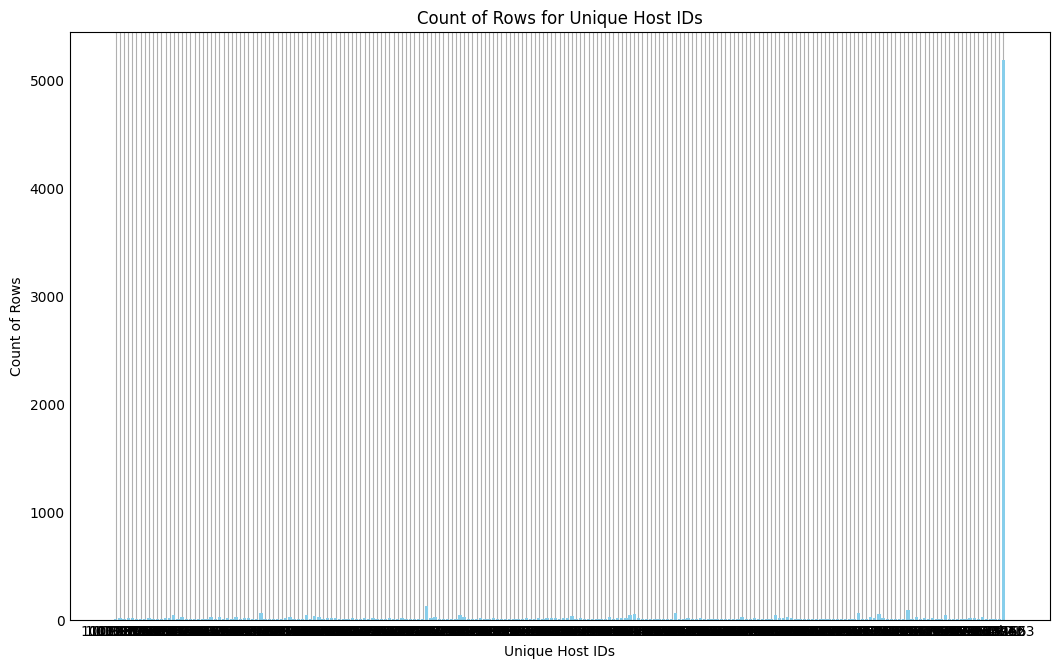

In [7]:
plt.style.use('_mpl-gallery')

plt.figure(figsize=(10, 6))
plt.bar(df_ids.index, df_ids['id'], color='skyblue')
plt.xlabel('Unique Host IDs')
plt.ylabel('Count of Rows')
plt.title('Count of Rows for Unique Host IDs')
#plt.xticks(host_id_counts.index)
plt.grid(axis='y')

plt.show()

## Review dates

From `first_review` and `last_review` to `reviewed_time_span`

In [8]:
df.isnull().sum()

id                                                 0
host_id                                            0
host_response_rate                               829
host_acceptance_rate                             535
neighbourhood_cleansed                             0
price                                              0
host_since                                         0
first_review                                     806
last_review                                      806
neighborhood_overview                           3208
host_location                                   1754
host_about                                      3529
host_response_time                               829
host_is_superhost                                205
host_listings_count                                0
host_total_listings_count                          0
host_has_profile_pic                               0
host_identity_verified                             0
latitude                                      

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
import pandas as pd
from feature_engine.datetime import DatetimeSubtraction
from feature_engine.pipeline import Pipeline
from feature_engine.creation import RelativeFeatures
from feature_engine.encoding import OneHotEncoder, OrdinalEncoder


review_dates_feature = ["first_review", "last_review"]

review_dates_pipeline = Pipeline(steps=[
    ('Review_dates_engineering', DatetimeSubtraction(variables="last_review",
                                                     reference="first_review",
                                                     output_unit="D",
                                                     drop_original=True,
                                                     new_variables_names=["days_active_reviews"]
                                                     )
     ),
    ("Imputation", SimpleImputer(strategy='median')),
    ("Standardize", MinMaxScaler()),
])


## Host Listings Count

`host_listings_count` as a percentage of `host_total_listings_count` and drop original columns

In [15]:
host_listings_feature = ["host_listings_count", "host_total_listings_count"]

host_listings_pipeline = Pipeline(steps=[
    ("Imputation", SimpleImputer(strategy="median")),
    ("relative_feature", RelativeFeatures(variables=[
        "host_listings_count"],
        reference=['"host_total_listings_count"'],
        func=['div'],
        drop_original=True
    )),
    ("Standardize", MinMaxScaler()),
])


## One-hot-encoding transformation

*This pipeline is also suited for all the binary variables at hand because of the `drop_last_binary` option*

In [19]:
ohe_features = ["neighbourhoods_cleansed", # categorical
                "host_is_superhost",       # binary
                "host_has_profile_pic",
                "host_identity_verified",
                "email_verification",
                "phone_verification",
                "work_email_verification"]

ohe_pipeline = Pipeline(steps=[
    ("One-hot-encoder", OneHotEncoder(drop_last_binary=True)),
    ("Imputation", SimpleImputer(strategy="most_frequent"))
])

## Ordinal categorical encoding



# Final transformer

In [18]:
df.head()

,id,host_id,host_response_rate,host_acceptance_rate,neighbourhood_cleansed,price,host_since,first_review,last_review,neighborhood_overview,...,calculated_host_listings_count_shared_rooms,reviews_per_month,airport_distance_km,ferretto_square_distance_km,roma_square_distance_km,rialto_bridge_distance_km,san_marco_square_distance_km,email_verification,phone_verification,work_email_verification
0,27491536,185612295,50.0,32.0,Centro Storico,211.0,2018-04-22,2018-10-01,2023-05-28,NaN,...,0,0.03,6.874816,8.510272,0.665043,1.165896,1.560678,t,t,f
1,829284975573971493,321485673,NaN,NaN,Centro Storico,1000.0,2019-12-27,NaT,NaT,NaN,...,0,NaN,6.707799,8.911650,1.112071,0.768878,1.238334,t,t,f
2,22925979,7074201,NaN,NaN,Centro Storico,55.0,2013-06-23,NaT,NaT,NaN,...,0,NaN,7.706987,10.683423,2.371963,1.082086,0.838850,t,t,f
3,33146077,184936719,100.0,55.0,Isole,190.0,2018-04-18,2019-11-04,2019-11-04,0,...,0,0.02,10.213909,13.283630,4.644740,3.659282,3.218084,t,t,f
4,603168,2985972,100.0,100.0,Centro Storico,80.0,2012-07-19,2012-10-27,2023-08-11,NaN,...,0,3.84,6.561673,8.436345,0.990182,1.218631,1.664298,t,t,f
